A Complete Guide To Survival Analysis In Python, part 2

https://www.kdnuggets.com/2020/07/guide-survival-analysis-python-part-2.html

Tags: Python, Statistics, Survival Analysis

*Continuing with the second of this three-part series covering a step-by-step review of statistical survival analysis, we look at a detailed example implementing the Kaplan-Meier fitter theory as well as the Nelson-Aalen fitter theory, both with examples and shared code.*

By Pratik Shukla, Aspiring machine learning engineer.

In the first article of this three-part series, we saw the basics of the Kaplan-Meier Estimator. Now, it’s time to implement the theory we discussed in the first part.

## Example 1: Kaplan-Meier Estimator (Without any groups)

Let’s code:

### 1. Import required libraries:

In [1]:
!pip install lifelines

     |████████████████████████████████| 348kB 6.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=5080cba6a9e6bd47cb9e7d6a991ee9a08d4fa86b7114e9be5639237bf35055e0
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [2]:
# Import required libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

### 2. Read the dataset:

In [4]:
from google.colab import files
uploaded = files.upload()

Saving cancer.csv to cancer.csv


In [5]:
import io
data = pd.read_csv(io.BytesIO(uploaded['cancer.csv']))

In [8]:
# Read the dataset :
#data = pd.read_csv("lung.csv")
print (data.head())

   Unnamed: 0  id             center      random  ... tstart enum  tstop  status
0           1   1  Scripps Institute  1989-06-07  ...      0    1    219       1
1           2   1  Scripps Institute  1989-06-07  ...    219    2    373       1
2           3   1  Scripps Institute  1989-06-07  ...    373    3    414       0
3           4   2  Scripps Institute  1989-06-07  ...      0    1      8       1
4           5   2  Scripps Institute  1989-06-07  ...      8    2     26       1

[5 rows x 17 columns]


### 3. Columns of our dataset:

In [13]:
data.columns

Index(['Unnamed: 0', 'inst', 'time', 'status', 'age', 'sex', 'ph.ecog',
       'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss'],
      dtype='object')

### 4. Additional info about dataset:

It gives us information about the data types and the number of rows in each column that has null values. It’s very important for us to remove the rows with a null value for some of the methods in survival analysis.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  228 non-null    int64  
 1   inst        227 non-null    float64
 2   time        228 non-null    int64  
 3   status      228 non-null    int64  
 4   age         228 non-null    int64  
 5   sex         228 non-null    int64  
 6   ph.ecog     227 non-null    float64
 7   ph.karno    227 non-null    float64
 8   pat.karno   225 non-null    float64
 9   meal.cal    181 non-null    float64
 10  wt.loss     214 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 19.7 KB


5. Statistical info about dataset:
It gives us some statistical information like the total number of rows, mean, standard deviation, minimum value, 25th percentile, 50th percentile, 75th percentile, and maximum value for each column in our dataset.

In [6]:
data.describe()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,228.00000,227.000000,228.000000,228.000000,228.000000,228.000000,227.000000,227.000000,225.000000,181.000000,214.000000
mean,114.50000,11.088106,305.232456,1.723684,62.447368,1.394737,0.951542,81.938326,79.955556,928.779006,9.831776
std,65.96211,8.303491,210.645543,0.448159,9.073457,0.489870,0.717872,12.327955,14.623177,402.174707,13.139902
min,1.00000,1.000000,5.000000,1.000000,39.000000,1.000000,0.000000,50.000000,30.000000,96.000000,-24.000000
25%,57.75000,3.000000,166.750000,1.000000,56.000000,1.000000,0.000000,75.000000,70.000000,635.000000,0.000000
50%,114.50000,11.000000,255.500000,2.000000,63.000000,1.000000,1.000000,80.000000,80.000000,975.000000,7.000000
75%,171.25000,16.000000,396.500000,2.000000,69.000000,2.000000,1.000000,90.000000,90.000000,1150.000000,15.750000
max,228.00000,33.000000,1022.000000,2.000000,82.000000,2.000000,3.000000,100.000000,100.000000,2600.000000,68.000000


### 6. Find out sex distribution using histogram:

This gives us a general idea about how our data is distributed. In the following graph, you can see that around 139 values have a status of 1, and around 90 values have a status of 2. It means that in our dataset, there are 139 males and around 90 females.

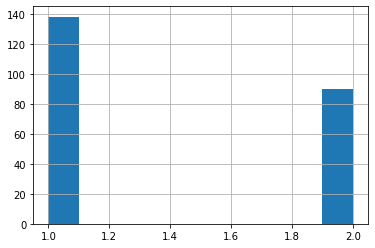

In [7]:
data["sex"].hist()

7. Create an object for KaplanMeierFitter:

In [8]:
# Create the object for our method :
kmf = KaplanMeierFitter() 

### 8. Organize the data:

Now we need to organize our data. We’ll add a new column in our dataset that is called “dead”. It stores the data about whether a person that is a part of our experiment is dead or alive (based on the status value). If our status value is 1 then that person is alive, and if our status value is 2 then the person is dead. It’s a very crucial step for what we need to do in the next step. As we are going to store our data in columns called censored and observed. Where observed data stores the value of dead persons in a specific timeline and censored data stores the value of alive persons or persons that we’re not going to investigate at that timeline.

In [9]:
# Organize our data :
# If status = 1 , then dead = 0
# If status = 2 , then dead = 1
data.loc[data.status == 1, 'dead'] = 0
data.loc[data.status == 2, 'dead'] = 1
print (data.head())

   Unnamed: 0  inst  time  status  ...  pat.karno  meal.cal  wt.loss  dead
0           1   3.0   306       2  ...      100.0    1175.0      NaN   1.0
1           2   3.0   455       2  ...       90.0    1225.0     15.0   1.0
2           3   3.0  1010       1  ...       90.0       NaN     15.0   0.0
3           4   5.0   210       2  ...       60.0    1150.0     11.0   1.0
4           5   1.0   883       2  ...       90.0       NaN      0.0   1.0

[5 rows x 12 columns]


### 9. Fitting our data into object:

Here our goal is to find the number of days a patient survived before they died. So our event of interest will be “death”, which is stored in the “dead” column. The first argument it takes is the timeline for our experiment.

In [10]:
# Fit the data into model.
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest (or death) occured.
kmf.fit(durations =  data["time"], event_observed = data["dead"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 228 total observations, 63 right-censored observations>

### 10. Event table:

One most important method of kmf object is “event_table”. It gives us various information for our data fitted. Let’s have a look at it column-by-column.

1. Event_at: It stores the value of the timeline for our dataset, i.e., when was the patient observed in our experiment or when was the experiment conducted. It can be the number of minutes, days, months, years etc. In our case, it’s going to be the number of days. It basically stores the value of survival days for a patient.

2. At_risk: It stores the number of current patients. At the start, it will be the total number of patients we are going to observe in our experiment. If at a certain time, new patients are added, then we have to increase it’s value accordingly. Basically, we can say that:

at_risk = current patients at_risk + entrance — removed

3. Entrance: It stores the value of new patients in a given timeline. It’ possible that while we have other patients, some new patients are also diagnosed with cancer. That’s why we add it here.

4. Censored: Our ultimate goal is to find the survival probability for a patient. If at a specific timeline person under experiment is alive, then that person goes into the censored category. If we don’t have information about when a patient died, then we add it to the censored data. Other possibilities are if a patient chooses to shift to another town where the experiment can’t be conducted, then we add that patient into the censored category.

5. Observed: The number of patients that died during the experiment.

6. Removed: It stores the values of patients that are no longer part of our experiment. If a person died or is censored, then they fall into this category. In short,

Removed = Observed + Censored


In [11]:
# Print the event table
# Removed = Observed + Censored
# Censored = Person that didn't die.(They are of no use to us!)
# Observed = Persons that died.
print(kmf.event_table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       228      228
5.0             1         1         0         0      228
11.0            3         3         0         0      227
12.0            1         1         0         0      224
13.0            2         2         0         0      223
...           ...       ...       ...       ...      ...
840.0           1         0         1         0        5
883.0           1         1         0         0        4
965.0           1         0         1         0        3
1010.0          1         0         1         0        2
1022.0          1         0         1         0        1

[187 rows x 5 columns]


### 11. Calculating the probability of survival for individual timelines:

Here we are going to use the following formula to count it by hand:

In [12]:
# Calculating survival probability by hand :
event_at_0 = kmf.event_table.iloc[0,:]
# Calculate the survival probability for t=0
surv_for_0 = (event_at_0.at_risk - event_at_0.observed)/event_at_0.at_risk
surv_for_0

1.0

###  12. Event_At_5:

In [13]:
# Calculating survival probability by hand :
event_at_5 = kmf.event_table.iloc[1,:]
# Calculate the survival probability for t=0
surv_for_5 = (event_at_5.at_risk - event_at_5.observed)/event_at_5.at_risk
surv_for_5

0.9956140350877193

### 13. Event_At_11:

In [14]:
# Calculating survival probability by hand :
event_at_11 = kmf.event_table.iloc[2,:]
# Calculate the survival probability for t=0
surv_for_11 = (event_at_11.at_risk - event_at_11.observed)/event_at_11.at_risk
surv_for_11

0.986784140969163

Now what we found here is the probability for a certain period of time only. What we want is the probability for the entire time period for a patient, i.e., the probability of the patient surviving all the rounds of experiment.

This seems confusing, right?

Let’s take a very simple example to understand the concept of conditional probability.

Let’ say we have a total of 15 balls in a non-transparent box. Out of the 15 balls, we have 7 black balls, 5 red balls, and 3 green balls. Here’s a pictorial view for that.

Now let’s find some probabilities!

Probability for choosing a red ball :

Notice that we have a total of 5 red balls out of 15 balls.



probability of choosing 2nd red ball:

Since we’ve removed a ball that was red, the total number of red balls we have is 4, and the total number of balls we have is 14.


Now what my point here is: What if we want to find the probability of both the balls selected to be red. This is our case here. Like we want to find the probability that we know that a patient has survived the 1st time interval, and we want to find the probability of them surviving the 2nd time interval given that they have survived the 1st time interval. My point here is we just don’t want to find the probability of the 2nd time interval only. We want the total probability of them surviving the time period.

In the case of the balls, we want to find out what’s the probability that both of the selected balls are red?



*Probability of both red balls*

Here our goal is to find the probability for the entire timeline of that person. Like they survived the 1st, 2nd, and 3rd timeslines, then our survival probability will be:



Getting back to our main example:

###  14. Surv_After_probability:

We want to find the probability that a patient has survived through all the timeline till now. Now we need to find the actual survival probability for a patient.

In [15]:
# Calculating actual probabilities :
surv_after_5 = surv_for_0 * surv_for_5
surv_after_11 = surv_for_0 * surv_for_5 * surv_for_11
print(surv_after_5)
print(surv_after_11)

0.9956140350877193
0.9824561403508771


###  15. Predict function:

Now the kmf object’s predict function does all of this work for us. But it’s always good to know the logic behind it.

In [16]:
# Our kmf object has done all these calculations for us :
print(kmf.predict(11))

0.9824561403508766


### 16. Finding survival probability for an array of the timeline:

We can find the probability for an array of time.

In [17]:
# For an array :
print(kmf.predict([0, 5, 11, 12]))

0     1.000000
5     0.995614
11    0.982456
12    0.978070
Name: KM_estimate, dtype: float64


### 17. Get survival probability for the whole timeline:

The kmf object’s survival_function_ gives us the complete data for our timeline.

In [18]:
# To get full list :
print(kmf.survival_function_)

          KM_estimate
timeline             
0.0          1.000000
5.0          0.995614
11.0         0.982456
12.0         0.978070
13.0         0.969298
...               ...
840.0        0.067127
883.0        0.050346
965.0        0.050346
1010.0       0.050346
1022.0       0.050346

[187 rows x 1 columns]


Explanation:

The survival probability for a patient at timeline 0 is 1. If you think it over, then you can understand that the probability that a person dies on the 1st day of diagnosis is nearly equal to 0. So we can say that the survival probability is as high as possible. As the timeline increases, the probability of survival decreases for a patient.

### 18. Median:

It provides the number of days where on average, 50% of patients survived.

In [19]:
# It provides the number of days where on average 50% of patients died.
print(kmf.median_survival_time_)

310.0


From the above code, we can say that, on average, a person lives 310 days after the day of diagnosis.

### 19. Plot the graph:

Here we can plot the graph for survival probability.

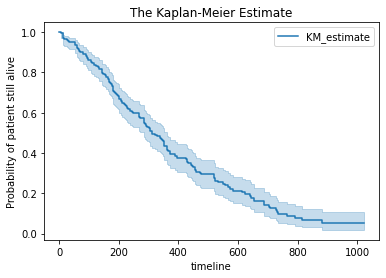

In [20]:
# Plot the graph:
kmf.plot()
plt.title("The Kaplan-Meier Estimate")
plt.ylabel("Probability of patient still alive")
plt.show()

### 20. Confidence interval:

The confidence interval gives us the range of values we are fairly sure our true values lie in. Here you can see in the above graph the light blue color shade represents the confidence interval of survival. From that, we can say that the probability at that timeline certainly lies between that confidence interval only.

In [21]:
print(kmf.confidence_interval_)

        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                   1.000000                1.000000
5.0                   0.969277                0.999381
11.0                  0.953935                0.993379
12.0                  0.948120                0.990813
13.0                  0.936682                0.985244
...                        ...                     ...
840.0                 0.030728                0.123060
883.0                 0.017866                0.108662
965.0                 0.017866                0.108662
1010.0                0.017866                0.108662
1022.0                0.017866                0.108662

[187 rows x 2 columns]


Now all the information we have is for the survival of a person. Now we are going to see what is the probability for a person to die at a certain timeline. Here notice that a higher survival probability is good for a person, but higher cumulative density (probability of a person to die) is not so good!

### 21. Probability of a person to die:



Here notice that the denominator value is the subjects at risk just before time (t). In a simple way, we can say that the person at_risk of the previous row.

The formula for cumulative density:



*Cumulative Density*

Calculate the probability by hand:

t = 0
t = 5
t = 11

Find the cumulative density:


In [22]:
# Probabaility of die:
# p(1022) = p(0) + ... + p(1022)
print(kmf.cumulative_density_)

          KM_estimate
timeline             
0.0          0.000000
5.0          0.004386
11.0         0.017544
12.0         0.021930
13.0         0.030702
...               ...
840.0        0.932873
883.0        0.949654
965.0        0.949654
1010.0       0.949654
1022.0       0.949654

[187 rows x 1 columns]


### 22. Plot the graph:

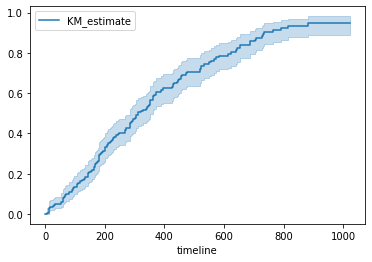

In [23]:
# Plot the graph:
kmf.plot_cumulative_density()

Notice that, as the number of survival days increases, the probability of a person dying increases.

## Example 2: Estimating hazard rates using Nelson-Aalen

### Hazard function:

The survival functions are a great way to summarize and visualize the survival dataset. However, it is not the only way. If we are curious about the hazard function h(t) of a population, we, unfortunately, can’t transform the Kaplan Meier estimate. For that, we use the Nelson-Aalen hazard function:



*Hazard Function*

where,

di = number of deaths at time ti

ni = number of patients at the start.

### 23. Import library:


In [24]:
# Hazard FUnction:
from lifelines import NelsonAalenFitter

### 24. Fitting the data:

In [25]:
naf = NelsonAalenFitter()
naf.fit(data["time"],event_observed = data["dead"])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 228 total observations, 63 right-censored observations>

### 25. Cumulative hazard:

Keep in mind we take at_risk of the current row:

In [26]:
print(naf.cumulative_hazard_)

          NA_estimate
timeline             
0.0          0.000000
5.0          0.004386
11.0         0.017660
12.0         0.022125
13.0         0.031114
...               ...
840.0        2.641565
883.0        2.891565
965.0        2.891565
1010.0       2.891565
1022.0       2.891565

[187 rows x 1 columns]


### 26. Plot the data:

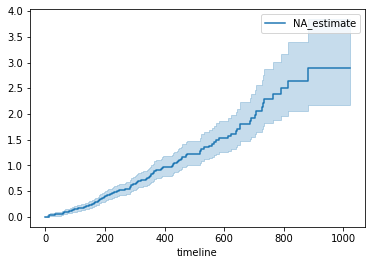

In [27]:
# Plot the cumulative_hazard
# naf.plot_cumulative_hazard()
naf.plot()

The cumulative hazard has less obvious understanding than the survival functions, but the hazard functions are the basis of more advanced techniques in survival analysis.

### 27. Predict a value:

In [28]:
# We can predict the value of a certain point :
print (naf.predict(1022))

2.8915648373471052


Putting it all together:

`Survival_Analysis_1.py` hosted with ❤ by GitHub

https://gist.githubusercontent.com/shuklapratik/3e6733f8e937f12b6ab37ac2237c3f30/raw/32a39f294e9d1d1b15b02b5120270dbaece208c7/Survival_Analysis_1.py

You can download the jupyter notebooks from here:

https://drive.google.com/drive/folders/1Vj9UNMfcsqP3S7D3-oQRjEuc2Gnw43dF

In the next article, we’ll discuss the log-rank test and cox regression with an example.

## Original:

https://medium.com/@shuklapratik22/b0e6354d599d

Reposted with permission.

## Bio: 

Pratik Shukla is an aspiring machine learning engineer who loves to put complex theories in simple ways. Pratik pursued his undergraduate in computer science and is going for a master's program in computer science at University of Southern California.  “Shoot for the moon. Even if you miss it you will land among the stars. -- Les Brown”

https://medium.com/@shuklapratik22

## Related:

**A Complete Guide To Survival Analysis In Python, part 1**

https://www.kdnuggets.com/2020/07/complete-guide-survival-analysis-python-part1.html

**Survival Analysis for Business Analytics**

https://www.kdnuggets.com/2017/11/survival-analysis-business-analytics.html

**The Challenges of Building a Predictive Churn Model**

https://www.kdnuggets.com/2017/03/datascience-building-predictive-churn-model.html
